#  Прогнозирование заказов такси

### Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час и построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

In [2]:
STATE = np.random.RandomState(12345)

In [3]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [5]:
# Проверим хронологическое расположение дат
print(data.index.is_monotonic)

True


In [6]:
# Отсортируем по индексу
data.sort_index(inplace=True)

In [7]:
# Сделаем ресемплирование с интервалом в 1 час
data = data.resample('1H').sum()

## Анализ

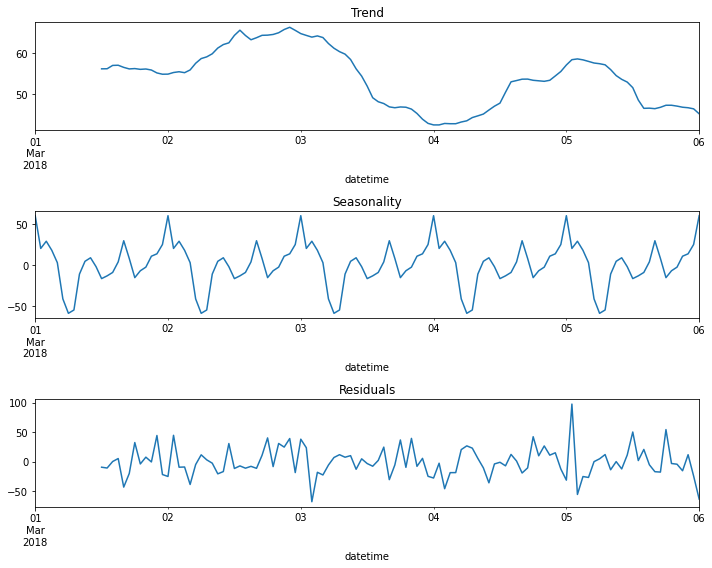

In [8]:
# Проверим данные на тренды и сезонность
decomposed = seasonal_decompose(data)

plt.figure(figsize=(10, 8))
plt.subplot(311)
decomposed.trend['2018-03-01 00:00:00':'2018-03-06 00:00:00'].plot(ax=plt.gca()) # Построим график тренда
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-06 00:00:00'].plot(ax=plt.gca()) # Построим график сезонности
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid['2018-03-01 00:00:00':'2018-03-06 00:00:00'].plot(ax=plt.gca()) # Построим график шумов
plt.title('Residuals')
plt.tight_layout()

По графикам выводы такие:
1. В трендах закономерности особо не видно. Может я взяла не то масштаб, конечно, но нас интересуют больше часовые интервалы, поэтому большие временные отрезки тут точно не нужны. А на маленьких закономерности нет, кажется.
2. В сезонности закономерность прослеживается - пик нагрузки в вечернее время до полуночи, которая резко снижается ночью и вновь начинает расти к утру. 

## Обучение

In [9]:
# Создадим функцию, создающую признаки для горизонта прогнозирования в 1 шаг = 1 часу
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day # создание признака, в котором хранится день как число
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag) #получение отстающих значений 

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean() # вычисление скользящего среднего


make_features(data, 9, 9)

In [10]:
data.head(10)

,num_orders,year,month,day,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,rolling_mean
datetime,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,2018,3,1,5,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,2018,3,1,6,6.0,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,2018,3,1,7,12.0,6.0,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 08:00:00,34,2018,3,1,8,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,NaN,NaN


In [11]:
# Разделим признаки на трейн и тест, в трейне дропнем пустые значения
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

In [12]:
# Разделим признаки и целевой признак
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [13]:
%%time
# Обучение модели линейной регрессии

lin_reg = LinearRegression()
param_grid={}
tscv = TimeSeriesSplit(n_splits=5)
grid_lin_reg = GridSearchCV(lin_reg, param_grid, verbose=10, cv=tscv, n_jobs=-1,
                          scoring='neg_root_mean_squared_error')
grid_lin_reg.fit(features_train, target_train)
print(grid_lin_reg.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START ............................................................
[CV 1/5; 1/1] END ........................................... total time=   0.1s
[CV 2/5; 1/1] START ............................................................
[CV 2/5; 1/1] END ........................................... total time=   0.1s
[CV 3/5; 1/1] START ............................................................
[CV 3/5; 1/1] END ........................................... total time=   0.1s
[CV 4/5; 1/1] START ............................................................
[CV 4/5; 1/1] END ........................................... total time=   0.1s
[CV 5/5; 1/1] START ............................................................
[CV 5/5; 1/1] END ........................................... total time=   0.1s
-31.462896383514725
CPU times: user 252 ms, sys: 335 ms, total: 586 ms
Wall time: 574 ms


In [14]:
pred_train = grid_lin_reg.predict(features_train)
mse = mean_squared_error(target_train, pred_train)

print('rmse=',mse ** 0.5)

rmse= 30.229293446556596


In [17]:
# RMSE для регрессии на кросс-валидации

print('rmse=',grid_lin_reg.best_score_ * (-1))

rmse= 31.462896383514725


In [18]:
%%time
# Обучение модели случайного леса

forest = RandomForestRegressor(random_state=STATE)
param_grid={'n_estimators':range(10, 50, 10), 'max_depth': range(5, 15)}
tscv = TimeSeriesSplit(n_splits=5)
grid_forest = GridSearchCV(forest, param_grid, verbose=10, cv=tscv, n_jobs=-1,
                          scoring='neg_root_mean_squared_error')
grid_forest.fit(features_train, target_train)
print(grid_forest.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5; 1/40] START max_depth=5, n_estimators=10...............................
[CV 1/5; 1/40] END .............max_depth=5, n_estimators=10; total time=   0.0s
[CV 2/5; 1/40] START max_depth=5, n_estimators=10...............................
[CV 2/5; 1/40] END .............max_depth=5, n_estimators=10; total time=   0.0s
[CV 3/5; 1/40] START max_depth=5, n_estimators=10...............................
[CV 3/5; 1/40] END .............max_depth=5, n_estimators=10; total time=   0.1s
[CV 4/5; 1/40] START max_depth=5, n_estimators=10...............................
[CV 4/5; 1/40] END .............max_depth=5, n_estimators=10; total time=   0.1s
[CV 5/5; 1/40] START max_depth=5, n_estimators=10...............................
[CV 5/5; 1/40] END .............max_depth=5, n_estimators=10; total time=   0.1s
[CV 1/5; 2/40] START max_depth=5, n_estimators=20...............................
[CV 1/5; 2/40] END .............max_depth=5, n_

In [19]:
pred_train = grid_forest.predict(features_train)
mse = mean_squared_error(target_train, pred_train)

print('rmse=',mse ** 0.5)

rmse= 11.625458369334678


In [20]:
# RMSE для случайного леса на кросс-валидации

print('rmse=', grid_forest.best_score_ * (-1))

rmse= 25.349708158051026


In [21]:
%%time
# Обучение модели CatBoost

catboost = CatBoostRegressor(loss_function='RMSE', silent=True, random_seed=0) #random_state=STATE)
param_grid={'n_estimators':range(1, 50, 10), 'depth':range(1,16), 'learning_rate':[0.1, 0.5, 0.8]}
tscv = TimeSeriesSplit(n_splits=5)
grid_catboost = GridSearchCV(catboost, param_grid, verbose=10, cv=tscv, n_jobs=-1,
                             scoring='neg_root_mean_squared_error')
grid_catboost.fit(features_train, target_train)
print(grid_catboost.best_score_)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[CV 1/5; 1/225] START depth=1, learning_rate=0.1, n_estimators=1................
[CV 1/5; 1/225] END depth=1, learning_rate=0.1, n_estimators=1; total time=   0.8s
[CV 2/5; 1/225] START depth=1, learning_rate=0.1, n_estimators=1................
[CV 2/5; 1/225] END depth=1, learning_rate=0.1, n_estimators=1; total time=   0.8s
[CV 3/5; 1/225] START depth=1, learning_rate=0.1, n_estimators=1................
[CV 3/5; 1/225] END depth=1, learning_rate=0.1, n_estimators=1; total time=   0.7s
[CV 4/5; 1/225] START depth=1, learning_rate=0.1, n_estimators=1................
[CV 4/5; 1/225] END depth=1, learning_rate=0.1, n_estimators=1; total time=   0.6s
[CV 5/5; 1/225] START depth=1, learning_rate=0.1, n_estimators=1................
[CV 5/5; 1/225] END depth=1, learning_rate=0.1, n_estimators=1; total time=   0.6s
[CV 1/5; 2/225] START depth=1, learning_rate=0.1, n_estimators=11...............
[CV 1/5; 2/225] END depth=1, learni

In [22]:
pred_train = grid_catboost.predict(features_train)
mse = mean_squared_error(target_train, pred_train)

print('rmse=',mse ** 0.5)

rmse= 21.08365459652726


In [23]:
# RMSE для CatBoost на кросс-валидации

print('rmse=', grid_catboost.best_score_ * (-1))

rmse= 26.18173773825648


По результатам обучения моделей лучшей оказалась модель случайного леса с RMSE = 11,62. Правда смущает, что обучилась модель очень быстро, обычно лес так не делает. 

## Тестирование

In [24]:
# Проверим модель на тестовой выборке
pred_test = grid_forest.predict(features_test)
mse = mean_squared_error(target_test, pred_test)

print('rmse=',mse ** 0.5)

rmse= 47.41967109838947


На тестовых данных модель показала себя хуже, но вписалась в требуемое значение. 

ВЫВОДЫ: Я загрузила и подготовила данные к дальнейшей работе. Проанализировала данные, посмотрела на тренды и сезонность. Далее обучила 3 модели: линейную регрессию, случайный лес и catboost. По результатам обучения лучшей моделью оказался случайный лес. На тесте он также показал значение RMSE в пределах требуемого.  